# Weather Type

The purpose of this notebook is to plot the circulation patterns associated with the various weather types and the time series of weather types

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature
import paraguayfloodspy.visualize as viz # custom plotting library
from paraguayfloodspy.xrutil import *
import matplotlib.patches as patches
%matplotlib inline

Define the extents to use for these plots

In [2]:
rain_extent = [270, 340, 5, -37.5]
my_extent = [220, 360, 5, -50]
months_plot = [11, 12, 1, 2]
savefigs = True

Get some consistent color schemes

In [3]:
cmap_streamfunc = 'PuOr'
cmap_streamfunc_a = 'PuOr'
cmap_rain = 'Greens'
cmap_raina = 'BrBG'

Read in raw data

In [4]:
prcpa = xr.open_dataarray("../_data/rainfall/subset/cpc_anom.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_200a = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_200_anom.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_850a = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_anom.nc").sel(time = slice('1979-11-01', '2016-02-29'))
prcp = xr.open_dataarray("../_data/rainfall/subset/cpc_raw.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_200 = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_200_raw.nc").sel(time = slice('1979-11-01', '2016-02-29'))
psi_850 = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_raw.nc").sel(time = slice('1979-11-01', '2016-02-29'))

In [5]:
wtypes = pd.read_csv("../_data/derived/WeatherTypes.csv", index_col='time', parse_dates=True)

Get the X and Y coordinates for plotting

In [6]:
X, Y = np.meshgrid(psi_200.lon, psi_200.lat)
Xp, Yp = np.meshgrid(prcp.lon, prcp.lat)
ncols = len(months_plot)

Define some contours for the true streamfunctions

In [7]:
lev200 = np.linspace(-1.2e8, 1.2e8, 13)
lev850 = np.linspace(-3.5e7, 3.5e7, 15)

Print out the climatological probability of each weather type

In [8]:
wt_counts = wtypes.groupby('wtype').size()
wt_prop = wt_counts / np.sum(wt_counts)
print(wt_prop)

wtype
1    0.197014
2    0.179184
3    0.172498
4    0.158012
5    0.152886
6    0.140406
dtype: float64


Repeat for NDJF 2015-16

In [9]:
wtypes['2015-11-01':'2016-02-29'].groupby('wtype').size() / 121

wtype
1    0.347107
2    0.148760
3    0.107438
4    0.190083
5    0.123967
6    0.090909
dtype: float64

## Composites

In [10]:
wt_all = np.unique(wtypes['wtype'])
ncols = len(wt_all)

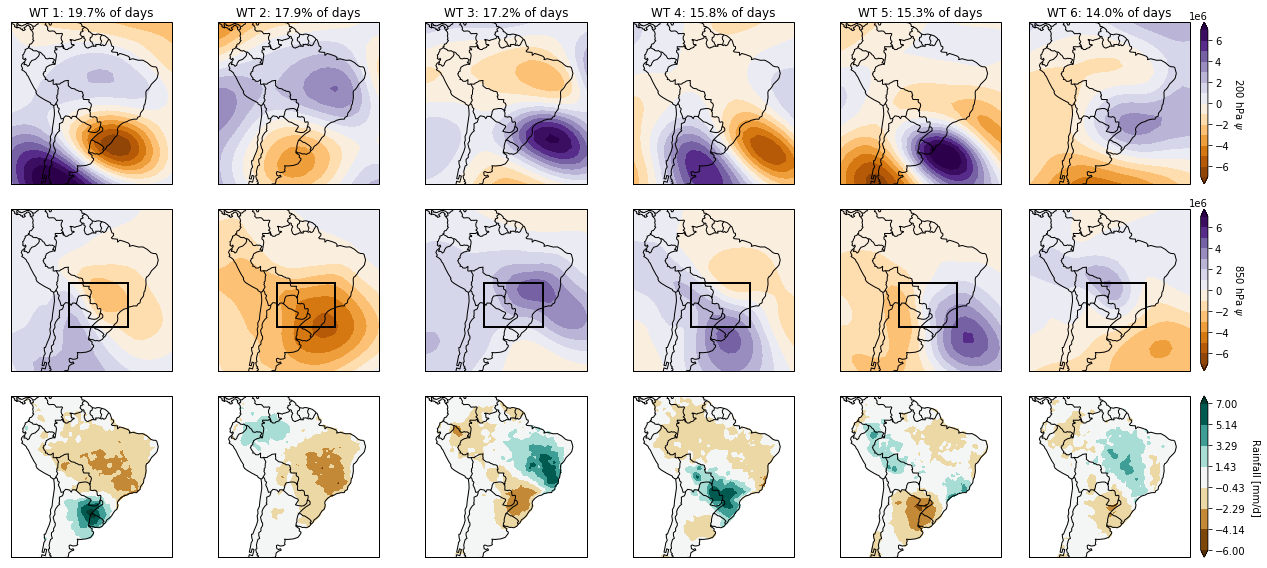

In [11]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 3 * ncols, proj = ccrs.PlateCarree(), figsize = [18, 8])
for i,wt in enumerate(wt_all):
    def selector(ds, wt):
        times = wtypes.loc[wtypes['wtype'] == wt].index
        ds = ds.sel(time = np.in1d(ds.time, times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Row 1: 200 hPa wind
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(wt, wt_prop.values[i]))
    C1 = ax.contourf(X, Y, selector(psi_200a, wt=wt), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc, extend='both', levels=np.linspace(-7e6, 7e6, 15))
    if i == (ncols - 1):
        cbar1 = fig.colorbar(C1, ax = ax)
        cbar1.formatter.set_powerlimits((6, 6))
        cbar1.update_ticks()
        cbar1.set_label(r'200 hPa $\psi$', rotation=270)
        cbar1.ax.get_yaxis().labelpad = 15

    # Row 2: 850 hPa wind
    ax = axes[1, i]
    C2 = ax.contourf(X, Y, selector(psi_850a, wt=wt), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc, extend="both", levels=np.linspace(-7e6, 7e6, 15))
    # Indicate WT Region
    ax.add_patch(
            patches.Rectangle((-65, -30), 20,15, #X,Y,dX,dY
                color = 'black', fill = None, linewidth=2, alpha=1))
    if i == (ncols - 1):
        cbar2 = fig.colorbar(C2, ax = ax)
        cbar2.formatter.set_powerlimits((7, 7))
        cbar2.update_ticks()
        cbar2.set_label(r'850 hPa $\psi$', rotation=270)
        cbar2.ax.get_yaxis().labelpad = 15

    # Row 3: Rainfall
    ax = axes[2, i]
    sub = selector(prcpa, wt=wt).values
    sub = np.ma.masked_invalid(sub)
    C3 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), 
                     cmap = cmap_raina, levels=np.linspace(-6, 7, 8), extend='both')
    if i == (ncols - 1):
        cbar3 = fig.colorbar(C3, ax = ax)
        cbar3.set_label(r'Rainfall [mm/d]', rotation=270)
        cbar3.ax.get_yaxis().labelpad = 15

viz.FormatAxes(axes[[0,1],:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None, extent=[275, 330, 10, -45])
viz.FormatAxes(axes[2,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, extent = [275, 330, 10, -45],
               ticks=None)

if savefigs:
    fig.savefig("../_figs/WTComposite.pdf", bbox_inches='tight')

## Time Series

In [12]:
prcp_rpy = prcp.sel(lon = slice(301.25, 304.75), lat = slice(-26.75, -22.75)).mean(dim=['lon', 'lat'])
prcp_rpy_sub = prcp_rpy.sel(time = slice('2015-11-01', '2016-02-29')).to_pandas()
prcp_rpy_sub = pd.DataFrame({'prcp': prcp_rpy_sub})
prcp_rpy = prcp_rpy.to_pandas()
prcp_rpy = prcp_rpy.dropna()

In [13]:
wtypes_sub = wtypes['2015-11-01':'2016-02-29']
wt_prcp = prcp_rpy_sub.join(wtypes_sub)
wt_prcp.head()

,prcp,wtype
time,,
2015-11-01,0.003657,3
2015-11-02,0.713011,6
2015-11-03,2.819442,4
2015-11-04,16.780805,4
2015-11-05,6.319572,5


In [14]:
plt.style.use('ggplot')

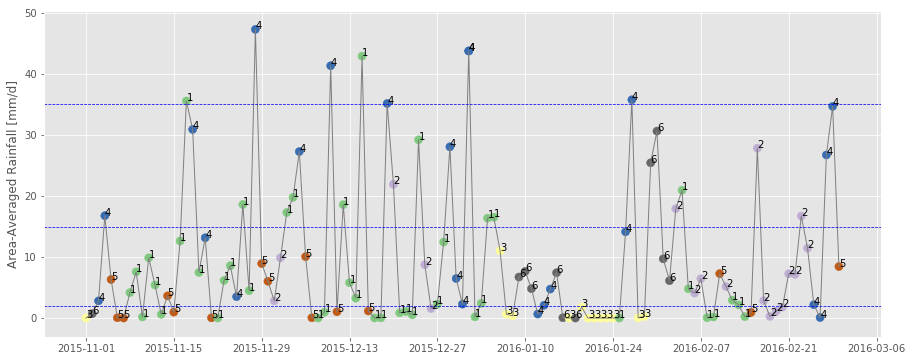

In [15]:
cmap = plt.get_cmap('Accent', 6)
plt.figure(figsize=(15,6))
plt.plot(wt_prcp.index, wt_prcp['prcp'], color='gray', linewidth=1)
plt.axhline(np.percentile(prcp_rpy, 50), label="p50", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 90), label="p90", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 99), label="p99", color='blue', linestyle='--', linewidth=0.75)
plt.scatter(wt_prcp.index, wt_prcp['prcp'], c=wt_prcp['wtype'], cmap=cmap, s=65)
plt.ylabel('Area-Averaged Rainfall [mm/d]')
for i,t in enumerate(wt_prcp.index):
    plt.text(t, wt_prcp.iloc[i]['prcp'], '{:d}'.format(np.int(wt_prcp.iloc[i]['wtype'])))
if savefigs:
    plt.savefig("../_figs/RainfallWeatherType.pdf", bbox_inches='tight')